In [4]:
# ====================================================================
# NOTEBOOK 2: ANALYSE ET INGÉNIERIE DES FEATURES
# ====================================================================
# Ce notebook se concentre sur l'analyse approfondie des features,
# la création de nouvelles variables et la sélection des meilleures
# caractéristiques pour la modélisation ML.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

class DrillingFeatureAnalyzer:
    """Analyseur de features pour les opérations de forage"""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA()
        
    def load_sample_data(self):
        """Génère des données d'exemple pour la démonstration"""
        np.random.seed(42)
        n_samples = 2000
        
        # Formation Pressure Data
        formation_data = {
            'WellDepth': np.random.normal(5000, 1000, n_samples),
            'WoBit': np.random.normal(25, 5, n_samples),
            'RoPen': np.random.normal(15, 3, n_samples),
            'BTBR': np.random.normal(120, 20, n_samples),
            'WBoPress': np.random.normal(2000, 300, n_samples),
            'HLoad': np.random.normal(150, 25, n_samples),
            'DPPress': np.random.normal(180, 30, n_samples),
            'Torque': np.random.normal(10000, 1500, n_samples),
            'FlowRate': np.random.normal(300, 50, n_samples),
            'MudWeight': np.random.normal(10, 1.5, n_samples),
            'Temperature': np.random.normal(150, 20, n_samples)
        }
        
        # Créer la pression de formation basée sur la physique
        formation_data['FPress'] = (
            0.433 * formation_data['WellDepth'] + 
            0.1 * formation_data['WBoPress'] + 
            0.05 * formation_data['MudWeight'] * formation_data['WellDepth'] / 1000 +
            np.random.normal(0, 100, n_samples)
        )
        
        # Kick Detection Data
        kick_data = {
            'FIn': np.random.normal(300, 20, n_samples),
            'FOut': np.random.normal(302, 20, n_samples),
            'ActiveGL': np.random.normal(100, 10, n_samples),
            'WBoPress': np.random.normal(2000, 200, n_samples),
            'MRFlow': np.random.normal(295, 15, n_samples),
            'HLoad': np.random.normal(150, 20, n_samples),
            'SMSpeed': np.random.normal(50, 10, n_samples),
            'StandPipePress': np.random.normal(2000, 300, n_samples),
            'CasingPress': np.random.normal(500, 100, n_samples)
        }
        
        return pd.DataFrame(formation_data), pd.DataFrame(kick_data)

In [6]:
# =============================================================================
# 1. CHARGEMENT ET EXPLORATION INITIALE DES DONNÉES
# =============================================================================

In [7]:
print("="*80)
print("ANALYSE ET INGÉNIERIE DES FEATURES - OPÉRATIONS DE FORAGE")
print("="*80)

# Initialisation de l'analyseur
analyzer = DrillingFeatureAnalyzer()

# Chargement des données
formation_data, kick_data = analyzer.load_sample_data()

print(f"\nDonnées de Formation de Pression: {formation_data.shape}")
print(f"Données de Détection de Kick: {kick_data.shape}")

# Aperçu des données
print("\n" + "="*50)
print("APERÇU DES DONNÉES DE FORMATION")
print("="*50)
print(formation_data.head())
print("\nInformations sur les données:")
print(formation_data.info())

print("\n" + "="*50)
print("APERÇU DES DONNÉES DE KICK")
print("="*50)
print(kick_data.head())
print("\nInformations sur les données:")
print(kick_data.info())

ANALYSE ET INGÉNIERIE DES FEATURES - OPÉRATIONS DE FORAGE

Données de Formation de Pression: (2000, 12)
Données de Détection de Kick: (2000, 9)

APERÇU DES DONNÉES DE FORMATION
     WellDepth      WoBit      RoPen        BTBR     WBoPress       HLoad  \
0  5496.714153  21.624109  12.409519   97.718373  1990.092421  133.037632   
1  4861.735699  24.277407  14.906390  107.381383  1848.904922  142.362513   
2  5647.688538  21.037900  15.054051  101.158796  1948.287513  135.065473   
3  6523.029856  23.460192  16.417891  109.040084  2214.419518  152.760451   
4  4765.846625  15.531927  10.899425  115.716994  2383.356997  179.929463   

      DPPress        Torque    FlowRate  MudWeight  Temperature       FPress  
0  215.244422   9663.638567  343.965365  10.482753   156.965725  2446.204261  
1  123.630572   9683.747922  301.965460   8.827963   155.666472  2279.489086  
2  170.166148  13353.141152  254.383724  11.037035   131.269603  2758.771429  
3  178.750199  11213.966356  276.875042   9.

In [8]:
# =============================================================================
# 2. ANALYSE STATISTIQUE DESCRIPTIVE
# =============================================================================

In [9]:
def analyze_descriptive_statistics(data, title):
    """Analyse statistique descriptive complète"""
    print(f"\n{'='*60}")
    print(f"ANALYSE DESCRIPTIVE - {title}")
    print("="*60)
    
    # Statistiques descriptives
    desc_stats = data.describe()
    print("\nStatistiques descriptives:")
    print(desc_stats.round(2))
    
    # Analyse de la distribution
    print("\nAnalyse de distribution:")
    for col in data.select_dtypes(include=[np.number]).columns:
        skewness = stats.skew(data[col].dropna())
        kurtosis = stats.kurtosis(data[col].dropna())
        print(f"{col:15s}: Skewness={skewness:6.3f}, Kurtosis={kurtosis:6.3f}")
    
    # Valeurs manquantes
    missing_data = data.isnull().sum()
    if missing_data.sum() > 0:
        print("\nValeurs manquantes:")
        print(missing_data[missing_data > 0])
    else:
        print("\nAucune valeur manquante détectée.")
    
    # Outliers (IQR method)
    print("\nAnalyse des outliers (méthode IQR):")
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
        outlier_percentage = (len(outliers) / len(data)) * 100
        print(f"{col:15s}: {len(outliers):4d} outliers ({outlier_percentage:5.2f}%)")
    
    return desc_stats

# Analyse des données de formation
formation_stats = analyze_descriptive_statistics(formation_data, "FORMATION PRESSURE")

# Analyse des données de kick
kick_stats = analyze_descriptive_statistics(kick_data, "KICK DETECTION")


ANALYSE DESCRIPTIVE - FORMATION PRESSURE

Statistiques descriptives:
       WellDepth    WoBit    RoPen     BTBR  WBoPress    HLoad  DPPress  \
count    2000.00  2000.00  2000.00  2000.00   2000.00  2000.00  2000.00   
mean     5045.08    24.97    14.86   119.91   2000.95   149.36   181.09   
std       988.47     5.03     3.00    20.67    296.56    24.82    30.00   
min      1758.73     9.90     5.47    46.23    823.28    65.61    87.52   
25%      4377.34    21.45    12.94   105.49   1808.09   133.10   160.91   
50%      5044.69    25.00    14.91   119.39   2004.26   149.00   181.54   
75%      5682.98    28.33    16.89   134.21   2198.76   165.59   201.04   
max      8852.73    44.63    24.34   190.58   3013.21   234.44   282.87   

         Torque  FlowRate  MudWeight  Temperature   FPress  
count   2000.00   2000.00    2000.00      2000.00  2000.00  
mean   10017.96    301.55      10.02       150.02  2383.59  
std     1522.74     49.93       1.50        19.96   439.45  
min     45

In [10]:
# =============================================================================
# 3. VISUALISATION DES DISTRIBUTIONS
# =============================================================================


VISUALISATION DES DISTRIBUTIONS


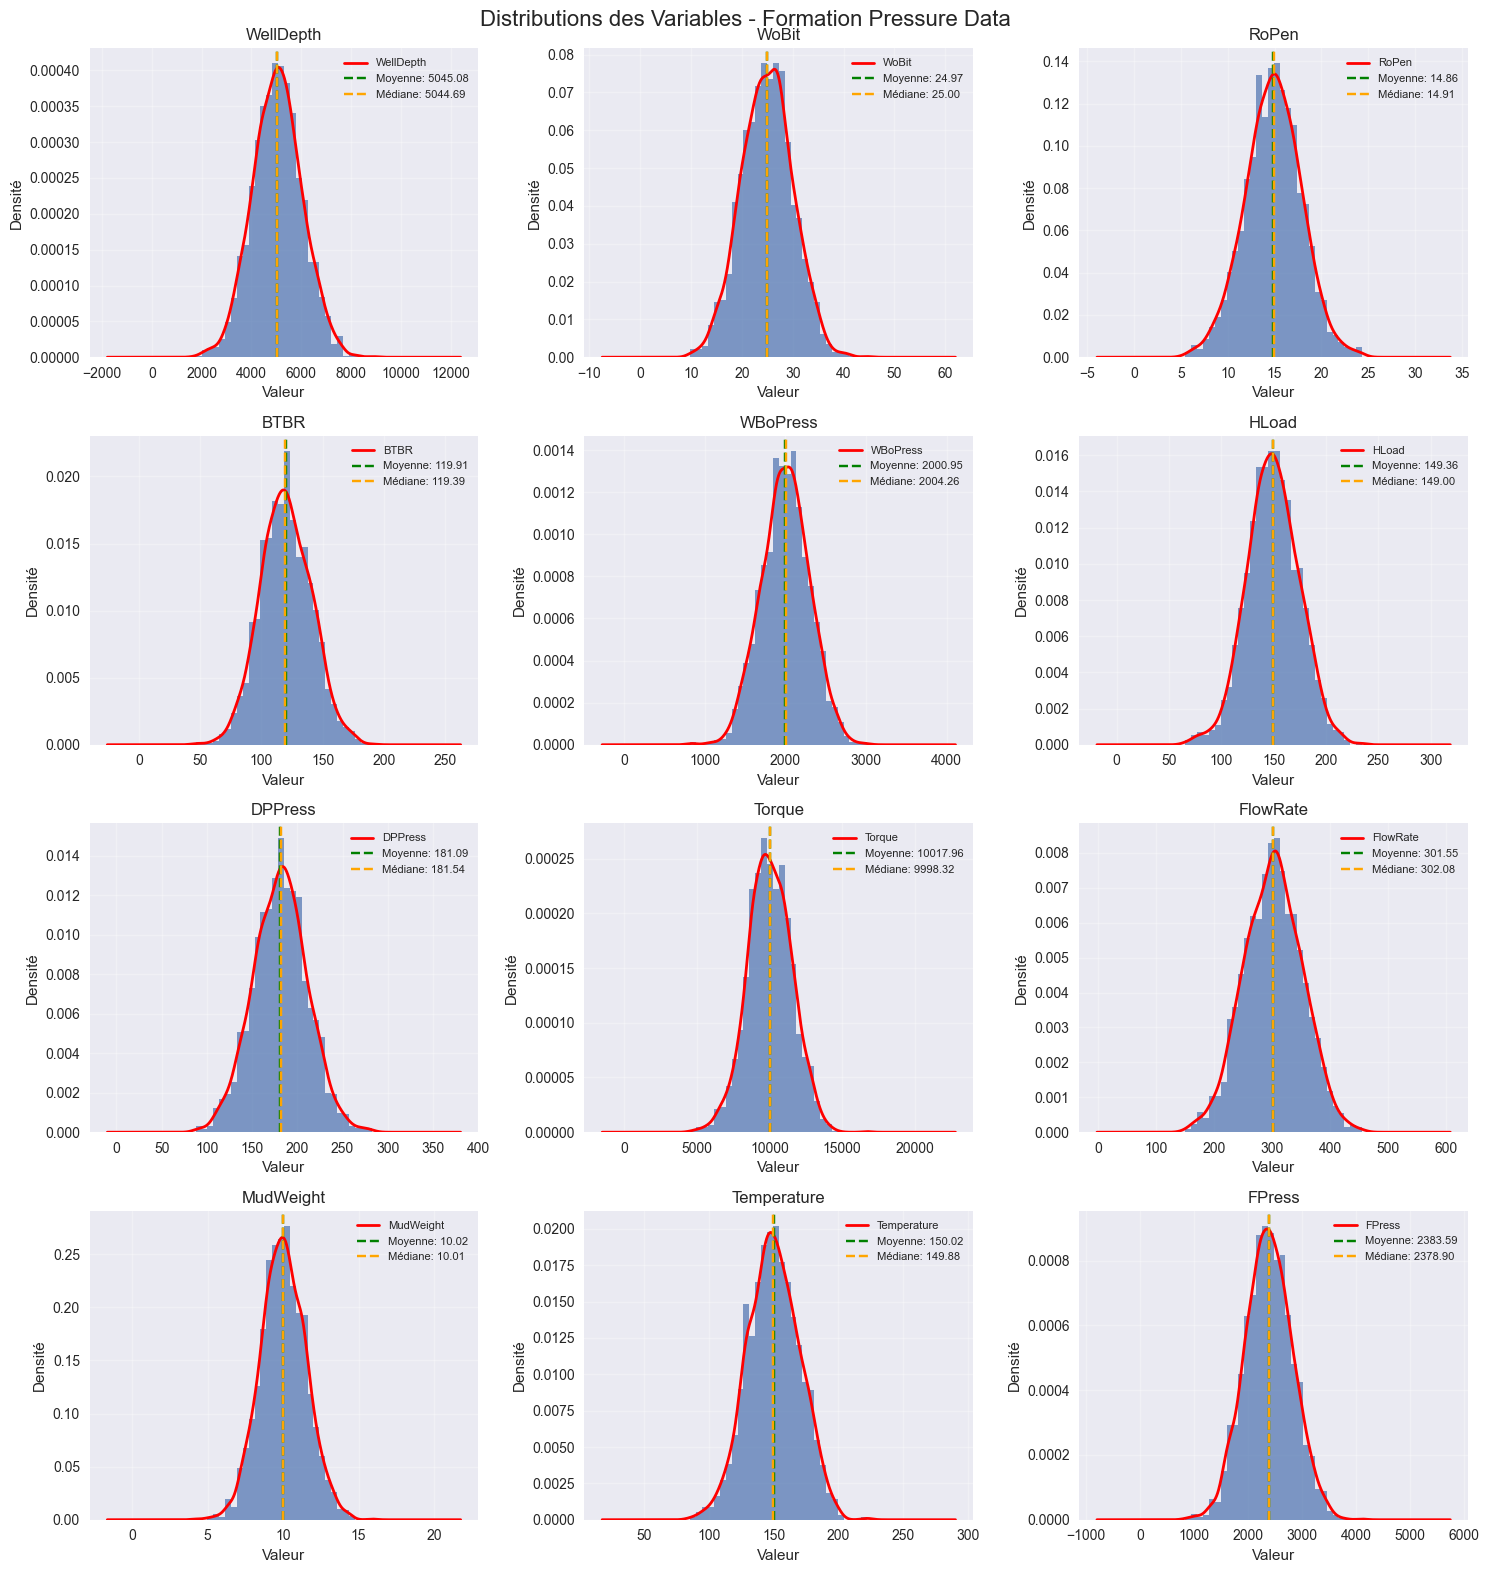

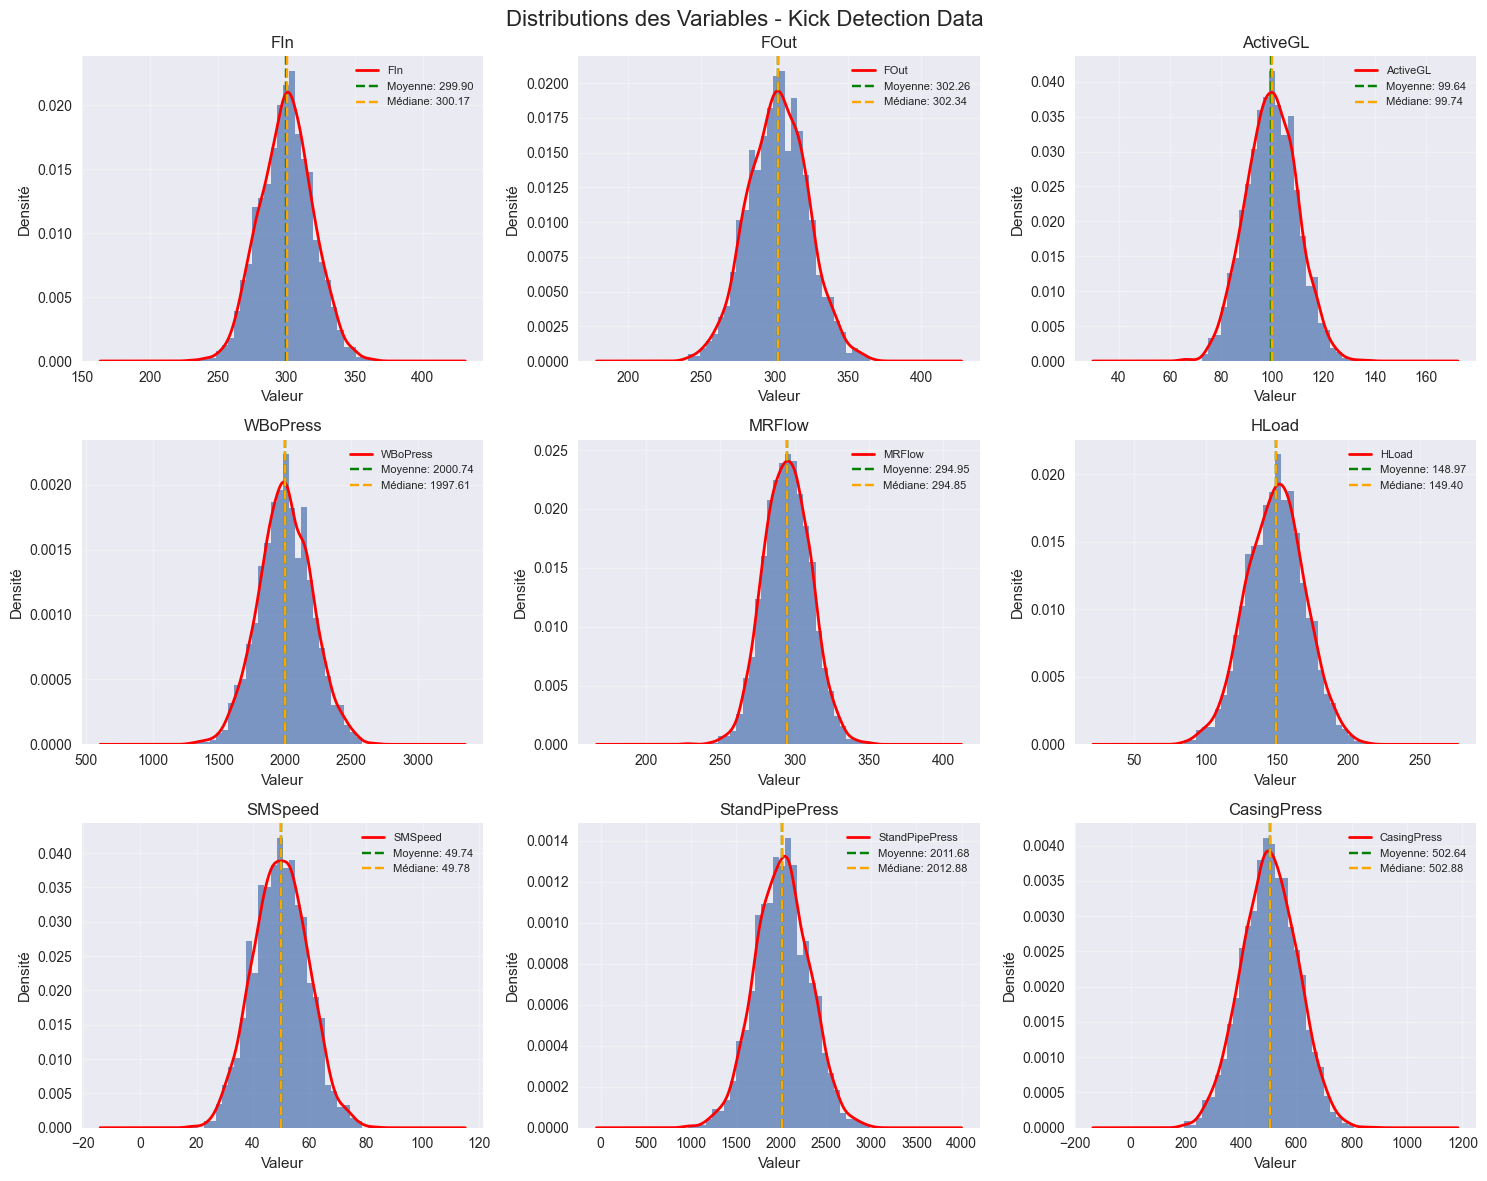

In [11]:
def plot_distributions(data, title, cols_per_row=3):
    """Visualise les distributions des variables"""
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    n_cols = len(numeric_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(15, 4*n_rows))
    fig.suptitle(f'Distributions des Variables - {title}', fontsize=16, y=0.98)
    
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        
        # Histogramme avec courbe de densité
        data[col].hist(bins=30, alpha=0.7, ax=ax, density=True)
        data[col].plot.density(ax=ax, color='red', linewidth=2)
        
        ax.set_title(f'{col}')
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Densité')
        ax.grid(True, alpha=0.3)
        
        # Ajouter statistiques
        mean_val = data[col].mean()
        median_val = data[col].median()
        ax.axvline(mean_val, color='green', linestyle='--', label=f'Moyenne: {mean_val:.2f}')
        ax.axvline(median_val, color='orange', linestyle='--', label=f'Médiane: {median_val:.2f}')
        ax.legend(fontsize=8)
    
    # Masquer les axes non utilisés
    for i in range(n_cols, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALISATION DES DISTRIBUTIONS")
print("="*60)

# Distributions des variables de formation
plot_distributions(formation_data, "Formation Pressure Data")

# Distributions des variables de kick
plot_distributions(kick_data, "Kick Detection Data")

In [12]:
# =============================================================================
# 4. ANALYSE DE CORRÉLATION
# =============================================================================


ANALYSE DE CORRÉLATION - FORMATION PRESSURE


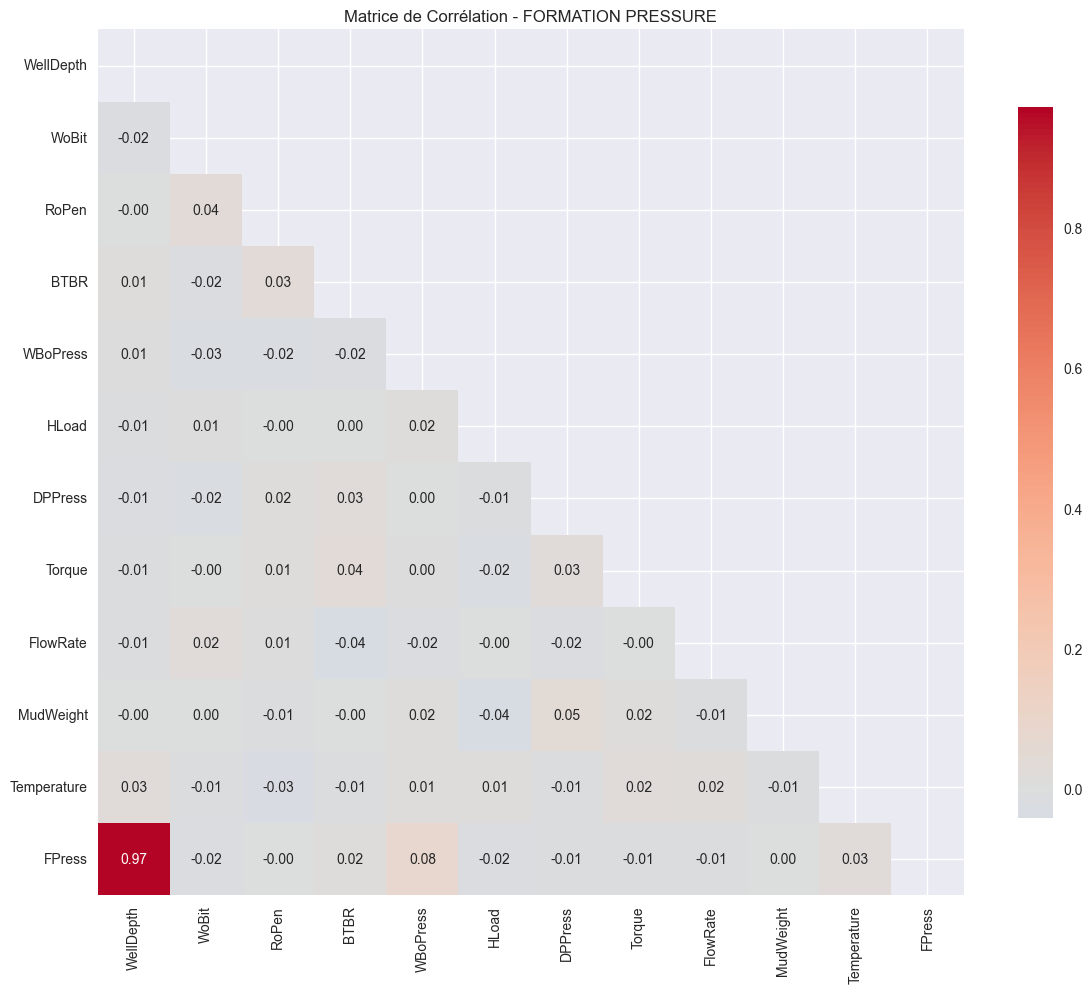


Corrélations les plus fortes:
         var1         var2  correlation  abs_correlation
10  WellDepth       FPress        0.971            0.971
44   WBoPress       FPress        0.085            0.085
53    DPPress    MudWeight        0.045            0.045
48      HLoad    MudWeight       -0.041            0.041
34       BTBR     FlowRate       -0.038            0.038
33       BTBR       Torque        0.036            0.036
11      WoBit        RoPen        0.036            0.036
28      RoPen  Temperature       -0.034            0.034
21      RoPen         BTBR        0.031            0.031
32       BTBR      DPPress        0.030            0.030

ANALYSE DE CORRÉLATION - KICK DETECTION


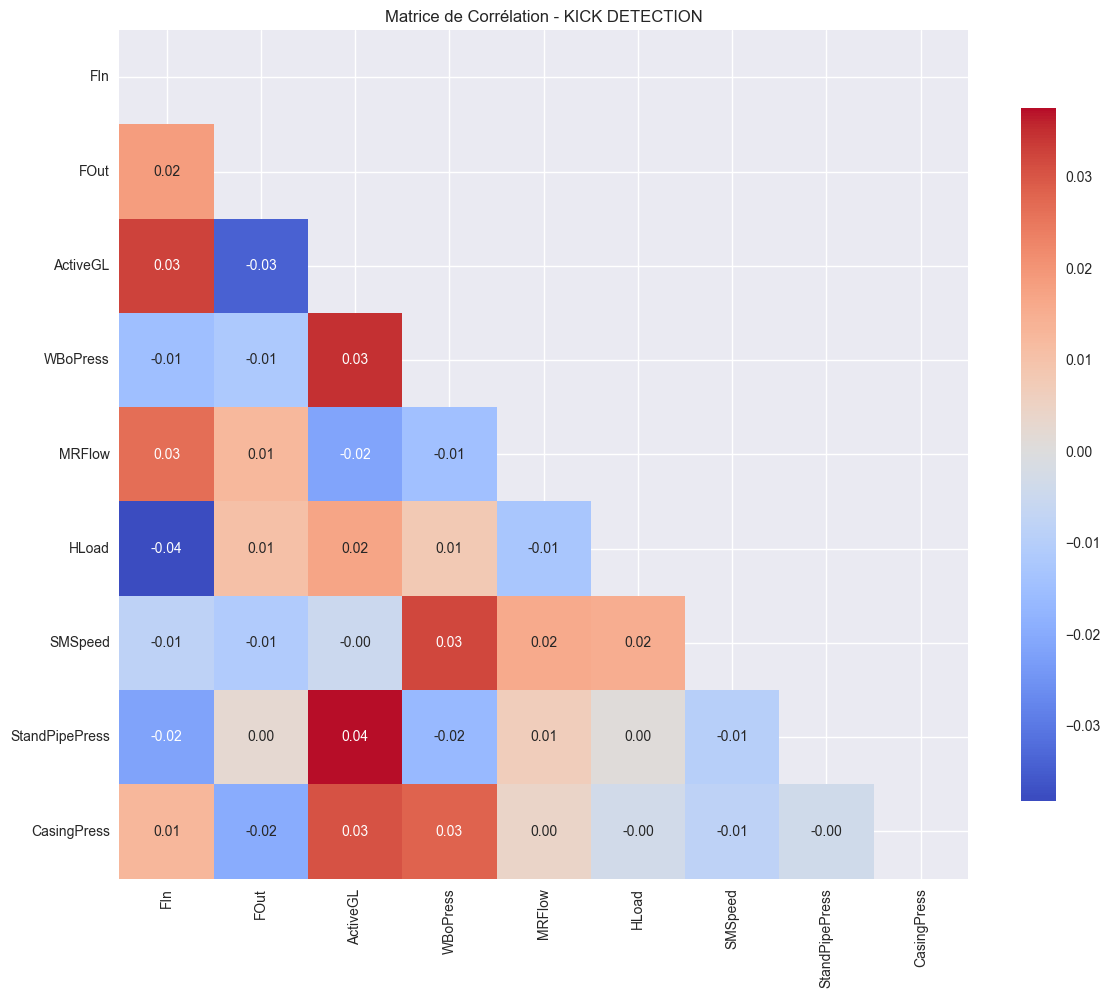


Corrélations les plus fortes:
        var1            var2  correlation  abs_correlation
4        FIn           HLoad       -0.038            0.038
19  ActiveGL  StandPipePress        0.037            0.037
15  ActiveGL        WBoPress        0.035            0.035
8       FOut        ActiveGL       -0.034            0.034
1        FIn        ActiveGL        0.033            0.033
23  WBoPress         SMSpeed        0.032            0.032
20  ActiveGL     CasingPress        0.031            0.031
25  WBoPress     CasingPress        0.028            0.028
3        FIn          MRFlow        0.026            0.026
6        FIn  StandPipePress       -0.022            0.022


In [13]:
def correlation_analysis(data, title):
    """Analyse complète de corrélation"""
    print(f"\n{'='*60}")
    print(f"ANALYSE DE CORRÉLATION - {title}")
    print("="*60)
    
    # Matrice de corrélation Pearson
    corr_matrix = data.corr()
    
    # Visualisation de la matrice de corrélation
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': .8})
    plt.title(f'Matrice de Corrélation - {title}')
    plt.tight_layout()
    plt.show()
    
    # Corrélations les plus fortes (hors diagonale)
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })
    
    corr_pairs_df = pd.DataFrame(corr_pairs)
    corr_pairs_df['abs_correlation'] = corr_pairs_df['correlation'].abs()
    corr_pairs_df = corr_pairs_df.sort_values('abs_correlation', ascending=False)
    
    print("\nCorrélations les plus fortes:")
    print(corr_pairs_df.head(10).round(3))
    
    return corr_matrix, corr_pairs_df

# Analyse de corrélation pour les données de formation
formation_corr, formation_pairs = correlation_analysis(formation_data, "FORMATION PRESSURE")

# Analyse de corrélation pour les données de kick
kick_corr, kick_pairs = correlation_analysis(kick_data, "KICK DETECTION")

In [14]:
# =============================================================================
# 5. INGÉNIERIE DES FEATURES
# =============================================================================

In [15]:
class FeatureEngineer:
    """Classe pour l'ingénierie des features de forage"""
    
    def __init__(self):
        pass
    
    def create_drilling_features(self, data, target_type='formation'):
        """Créer de nouvelles features basées sur la physique du forage"""
        engineered_data = data.copy()
        
        if target_type == 'formation':
            # Features pour la pression de formation
            if all(col in data.columns for col in ['WellDepth', 'MudWeight']):
                engineered_data['MudWeightGradient'] = data['MudWeight'] * 0.052
                engineered_data['HydrostaticPress'] = data['WellDepth'] * data['MudWeight'] * 0.052
            
            if all(col in data.columns for col in ['WoBit', 'BTBR']):
                engineered_data['SpecificEnergy'] = data['WoBit'] * 1000 / (data['BTBR'] + 1e-6)
            
            if all(col in data.columns for col in ['RoPen', 'WoBit']):
                engineered_data['MechEfficiency'] = data['RoPen'] / (data['WoBit'] + 1e-6)
            
            if all(col in data.columns for col in ['WBoPress', 'WellDepth']):
                engineered_data['PressureGradient'] = data['WBoPress'] / (data['WellDepth'] + 1e-6)
            
            if 'Torque' in data.columns and 'RoPen' in data.columns:
                engineered_data['TorqueRatio'] = data['Torque'] / (data['RoPen'] + 1e-6)
            
        elif target_type == 'kick':
            # Features pour la détection de kick
            if all(col in data.columns for col in ['FIn', 'FOut']):
                engineered_data['FlowBalance'] = data['FOut'] - data['FIn']
                engineered_data['FlowRatio'] = data['FOut'] / (data['FIn'] + 1e-6)
                engineered_data['FlowImbalance'] = np.abs(engineered_data['FlowBalance'])
            
            if 'ActiveGL' in data.columns:
                engineered_data['ActiveGL_MA3'] = data['ActiveGL'].rolling(window=3, min_periods=1).mean()
                engineered_data['ActiveGL_MA5'] = data['ActiveGL'].rolling(window=5, min_periods=1).mean()
                engineered_data['ActiveGL_Change'] = data['ActiveGL'].diff()
                engineered_data['ActiveGL_ChangeRate'] = data['ActiveGL'].pct_change()
            
            if all(col in data.columns for col in ['StandPipePress', 'CasingPress']):
                engineered_data['PressureDiff'] = data['StandPipePress'] - data['CasingPress']
            
            if 'SMSpeed' in data.columns and 'HLoad' in data.columns:
                engineered_data['PowerIndex'] = data['SMSpeed'] * data['HLoad']
        
        # Features temporelles (si on simule des données temporelles)
        if len(data) > 10:
            for col in data.select_dtypes(include=[np.number]).columns:
                if col not in ['FPress', 'ActiveGL']:  # Éviter les targets
                    # Moving averages
                    engineered_data[f'{col}_MA3'] = data[col].rolling(window=3, min_periods=1).mean()
                    engineered_data[f'{col}_Std3'] = data[col].rolling(window=3, min_periods=1).std()
                    
                    # Lag features
                    engineered_data[f'{col}_Lag1'] = data[col].shift(1)
                    
                    # Rate of change
                    engineered_data[f'{col}_ROC'] = data[col].pct_change()
        
        # Features d'interaction (les plus importantes seulement pour éviter la curse of dimensionality)
        numeric_cols = data.select_dtypes(include=[np.number]).columns[:5]  # Limiter aux 5 premières
        for i, col1 in enumerate(numeric_cols):
            for col2 in numeric_cols[i+1:]:
                if col1 != col2:
                    engineered_data[f'{col1}_x_{col2}'] = data[col1] * data[col2]
                    engineered_data[f'{col1}_div_{col2}'] = data[col1] / (data[col2] + 1e-6)
        
        # Features polynomiales (degré 2 pour les variables importantes)
        important_cols = data.columns[:3] if len(data.columns) >= 3 else data.columns
        for col in important_cols:
            if data[col].dtype in [np.float64, np.int64]:
                engineered_data[f'{col}_squared'] = data[col] ** 2
                engineered_data[f'{col}_sqrt'] = np.sqrt(np.abs(data[col]))
        
        return engineered_data
    
    def select_features(self, X, y, method='mutual_info', k=20):
        """Sélection des meilleures features"""
        if method == 'mutual_info':
            selector = SelectKBest(score_func=mutual_info_regression, k=k)
        else:  # f_regression
            selector = SelectKBest(score_func=f_regression, k=k)
        
        X_selected = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()]
        scores = selector.scores_[selector.get_support()]
        
        feature_scores = pd.DataFrame({
            'Feature': selected_features,
            'Score': scores
        }).sort_values('Score', ascending=False)
        
        return X_selected, selected_features, feature_scores

# Initialisation du feature engineer
feature_engineer = FeatureEngineer()

print("\n" + "="*60)
print("INGÉNIERIE DES FEATURES")
print("="*60)

# Création de nouvelles features pour la formation
print("\nCréation de features pour la pression de formation...")
formation_enhanced = feature_engineer.create_drilling_features(formation_data, 'formation')
print(f"Features originales: {formation_data.shape[1]}")
print(f"Features après ingénierie: {formation_enhanced.shape[1]}")
print(f"Nouvelles features créées: {formation_enhanced.shape[1] - formation_data.shape[1]}")

# Création de nouvelles features pour kick
print("\nCréation de features pour la détection de kick...")
kick_enhanced = feature_engineer.create_drilling_features(kick_data, 'kick')
print(f"Features originales: {kick_data.shape[1]}")
print(f"Features après ingénierie: {kick_enhanced.shape[1]}")
print(f"Nouvelles features créées: {kick_enhanced.shape[1] - kick_data.shape[1]}")

# Affichage des nouvelles features créées
print("\nExemples de nouvelles features (Formation):")
new_formation_features = [col for col in formation_enhanced.columns if col not in formation_data.columns]
for i, feature in enumerate(new_formation_features[:10]):
    print(f"{i+1:2d}. {feature}")

print("\nExemples de nouvelles features (Kick):")
new_kick_features = [col for col in kick_enhanced.columns if col not in kick_data.columns]
for i, feature in enumerate(new_kick_features[:10]):
    print(f"{i+1:2d}. {feature}")


INGÉNIERIE DES FEATURES

Création de features pour la pression de formation...
Features originales: 12
Features après ingénierie: 88
Nouvelles features créées: 76

Création de features pour la détection de kick...
Features originales: 9
Features après ingénierie: 76
Nouvelles features créées: 67

Exemples de nouvelles features (Formation):
 1. MudWeightGradient
 2. HydrostaticPress
 3. SpecificEnergy
 4. MechEfficiency
 5. PressureGradient
 6. TorqueRatio
 7. WellDepth_MA3
 8. WellDepth_Std3
 9. WellDepth_Lag1
10. WellDepth_ROC

Exemples de nouvelles features (Kick):
 1. FlowBalance
 2. FlowRatio
 3. FlowImbalance
 4. ActiveGL_MA3
 5. ActiveGL_MA5
 6. ActiveGL_Change
 7. ActiveGL_ChangeRate
 8. PressureDiff
 9. PowerIndex
10. FIn_MA3


In [16]:
# =============================================================================
# 6. SÉLECTION DES FEATURES
# =============================================================================

In [17]:
print("\n" + "="*60)
print("SÉLECTION DES FEATURES")
print("="*60)

# Sélection pour la pression de formation
if 'FPress' in formation_enhanced.columns:
    X_formation = formation_enhanced.drop('FPress', axis=1)
    y_formation = formation_enhanced['FPress']
    
    # Nettoyer les données (remplacer inf et nan)
    X_formation = X_formation.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    print("\nSélection des features pour la pression de formation...")
    X_formation_selected, selected_features_formation, scores_formation = feature_engineer.select_features(
        X_formation, y_formation, method='mutual_info', k=15
    )
    
    print(f"Features sélectionnées: {len(selected_features_formation)}")
    print("\nTop 10 features par score d'importance mutuelle:")
    print(scores_formation.head(10))

# Sélection pour la détection de kick (utiliser ActiveGL comme proxy)
if 'ActiveGL' in kick_enhanced.columns:
    X_kick = kick_enhanced.drop('ActiveGL', axis=1)
    y_kick = kick_enhanced['ActiveGL']
    
    # Nettoyer les données
    X_kick = X_kick.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    print("\n\nSélection des features pour la détection de kick...")
    X_kick_selected, selected_features_kick, scores_kick = feature_engineer.select_features(
        X_kick, y_kick, method='mutual_info', k=15
    )
    
    print(f"Features sélectionnées: {len(selected_features_kick)}")
    print("\nTop 10 features par score d'importance mutuelle:")
    print(scores_kick.head(10))


SÉLECTION DES FEATURES

Sélection des features pour la pression de formation...
Features sélectionnées: 15

Top 10 features par score d'importance mutuelle:
                   Feature     Score
14          WellDepth_sqrt  1.445146
0                WellDepth  1.444415
13       WellDepth_squared  1.444230
11    WellDepth_x_WBoPress  0.597056
1         HydrostaticPress  0.485286
12  WellDepth_div_WBoPress  0.414997
2         PressureGradient  0.404392
9         WellDepth_x_BTBR  0.379134
10      WellDepth_div_BTBR  0.366946
4            WellDepth_ROC  0.331083


Sélection des features pour la détection de kick...
Features sélectionnées: 15

Top 10 features par score d'importance mutuelle:
                Feature     Score
14        ActiveGL_sqrt  6.313218
13     ActiveGL_squared  6.281186
12  ActiveGL_div_MRFlow  0.814520
11    ActiveGL_x_MRFlow  0.783925
5        FIn_x_ActiveGL  0.650622
6      FIn_div_ActiveGL  0.613923
8     FOut_div_ActiveGL  0.598039
7       FOut_x_ActiveGL  0.56357

In [18]:
# =============================================================================
# 7. ANALYSE EN COMPOSANTES PRINCIPALES (PCA)
# =============================================================================


ANALYSE EN COMPOSANTES PRINCIPALES (PCA)

Analyse PCA - Formation Pressure
----------------------------------------
Variance expliquée par composante:
PC 1:  0.156 (Cumulée:  0.156)
PC 2:  0.133 (Cumulée:  0.289)
PC 3:  0.107 (Cumulée:  0.396)
PC 4:  0.100 (Cumulée:  0.496)
PC 5:  0.070 (Cumulée:  0.566)
PC 6:  0.059 (Cumulée:  0.625)
PC 7:  0.055 (Cumulée:  0.681)
PC 8:  0.053 (Cumulée:  0.733)
PC 9:  0.052 (Cumulée:  0.785)
PC10:  0.050 (Cumulée:  0.835)


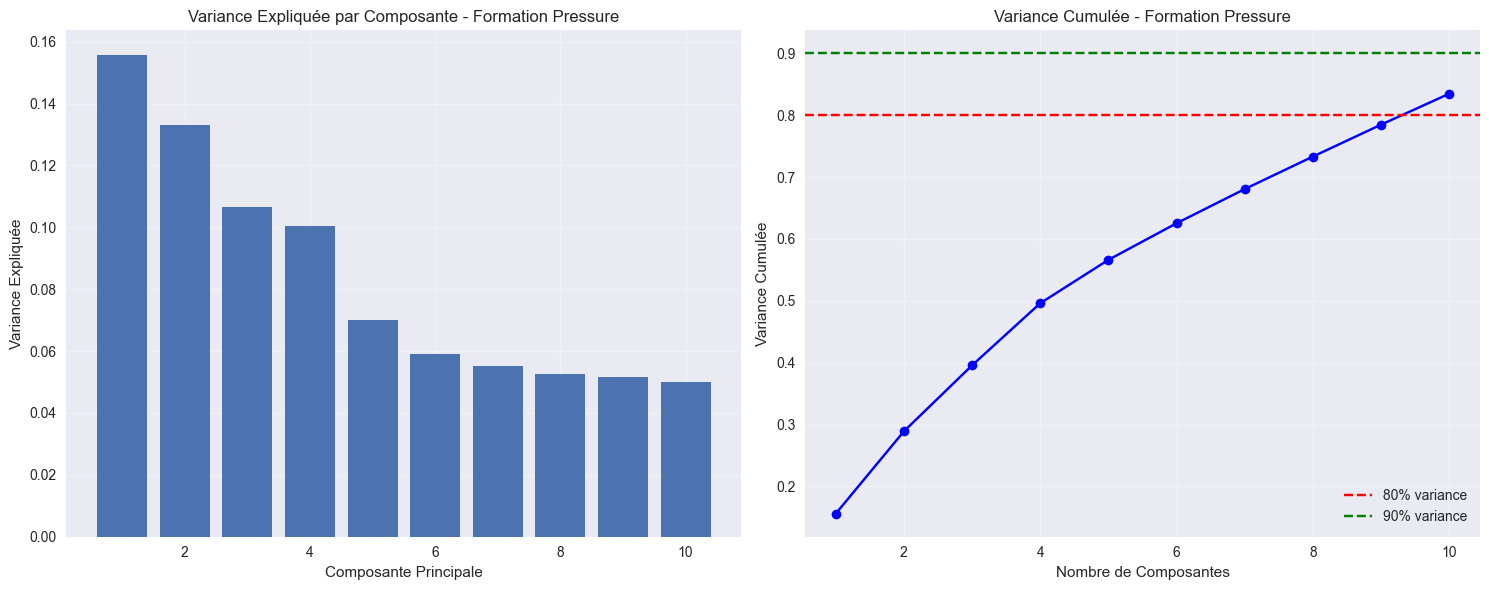


Analyse PCA - Kick Detection
----------------------------------------
Variance expliquée par composante:
PC 1:  0.162 (Cumulée:  0.162)
PC 2:  0.102 (Cumulée:  0.265)
PC 3:  0.101 (Cumulée:  0.366)
PC 4:  0.096 (Cumulée:  0.462)
PC 5:  0.089 (Cumulée:  0.551)
PC 6:  0.078 (Cumulée:  0.629)
PC 7:  0.061 (Cumulée:  0.690)
PC 8:  0.054 (Cumulée:  0.743)
PC 9:  0.051 (Cumulée:  0.794)
PC10:  0.049 (Cumulée:  0.843)


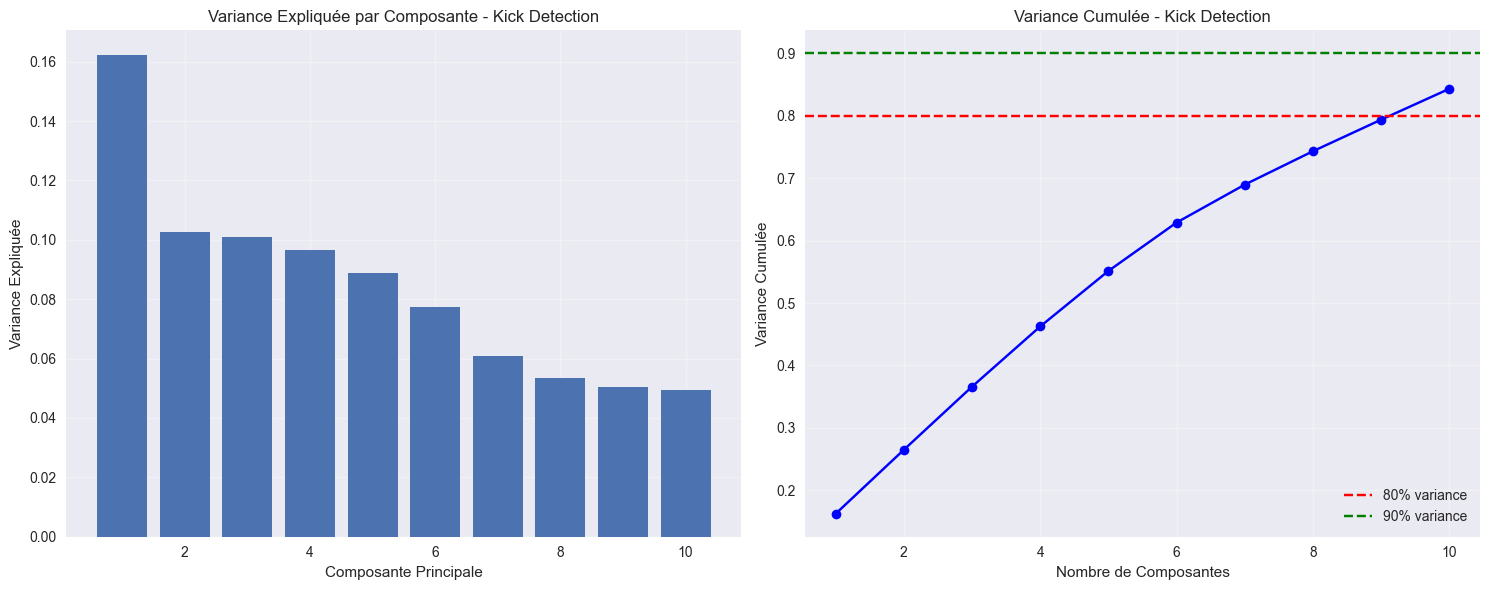

In [19]:
print("\n" + "="*60)
print("ANALYSE EN COMPOSANTES PRINCIPALES (PCA)")
print("="*60)

def perform_pca_analysis(X, title, n_components=10):
    """Effectue une analyse PCA complète"""
    print(f"\nAnalyse PCA - {title}")
    print("-" * 40)
    
    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Variance expliquée
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"Variance expliquée par composante:")
    for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
        print(f"PC{i+1:2d}: {var_ratio:6.3f} (Cumulée: {cum_var:6.3f})")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Variance expliquée par composante
    ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    ax1.set_xlabel('Composante Principale')
    ax1.set_ylabel('Variance Expliquée')
    ax1.set_title(f'Variance Expliquée par Composante - {title}')
    ax1.grid(True, alpha=0.3)
    
    # Variance cumulée
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    ax2.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
    ax2.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
    ax2.set_xlabel('Nombre de Composantes')
    ax2.set_ylabel('Variance Cumulée')
    ax2.set_title(f'Variance Cumulée - {title}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return pca, X_pca, explained_variance_ratio

# PCA sur les données de formation
if 'X_formation' in locals():
    pca_formation, X_formation_pca, var_ratio_formation = perform_pca_analysis(
        X_formation.iloc[:, :20], "Formation Pressure", n_components=10
    )

# PCA sur les données de kick
if 'X_kick' in locals():
    pca_kick, X_kick_pca, var_ratio_kick = perform_pca_analysis(
        X_kick.iloc[:, :20], "Kick Detection", n_components=10
    )

In [20]:
# =============================================================================
# 8. DÉTECTION ET TRAITEMENT DES OUTLIERS
# =============================================================================

In [21]:
print("\n" + "="*60)
print("DÉTECTION ET TRAITEMENT DES OUTLIERS")
print("="*60)

def detect_and_treat_outliers(data, method='iqr', factor=1.5):
    """Détection et traitement des outliers"""
    print(f"\nDétection des outliers - Méthode: {method.upper()}")
    
    outlier_info = {}
    cleaned_data = data.copy()
    
    for col in data.select_dtypes(include=[np.number]).columns:
        if method == 'iqr':
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            outliers_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
            
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data[col]))
            outliers_mask = z_scores > factor
        
        n_outliers = outliers_mask.sum()
        outlier_percentage = (n_outliers / len(data)) * 100
        
        outlier_info[col] = {
            'count': n_outliers,
            'percentage': outlier_percentage,
            'bounds': (lower_bound if method == 'iqr' else None, 
                      upper_bound if method == 'iqr' else None)
        }
        
        # Traitement: cap à l'IQR
        if method == 'iqr' and n_outliers > 0:
            cleaned_data[col] = np.clip(data[col], lower_bound, upper_bound)
        
        print(f"{col:15s}: {n_outliers:4d} outliers ({outlier_percentage:5.2f}%)")
    
    return cleaned_data, outlier_info

# Traitement des outliers pour les données de formation
formation_cleaned, formation_outlier_info = detect_and_treat_outliers(
    formation_enhanced, method='iqr', factor=1.5
)

# Traitement des outliers pour les données de kick
kick_cleaned, kick_outlier_info = detect_and_treat_outliers(
    kick_enhanced, method='iqr', factor=1.5
)


DÉTECTION ET TRAITEMENT DES OUTLIERS

Détection des outliers - Méthode: IQR
WellDepth      :   17 outliers ( 0.85%)
WoBit          :   13 outliers ( 0.65%)
RoPen          :   22 outliers ( 1.10%)
BTBR           :   10 outliers ( 0.50%)
WBoPress       :   13 outliers ( 0.65%)
HLoad          :   25 outliers ( 1.25%)
DPPress        :   16 outliers ( 0.80%)
Torque         :   16 outliers ( 0.80%)
FlowRate       :   10 outliers ( 0.50%)
MudWeight      :   17 outliers ( 0.85%)
Temperature    :    9 outliers ( 0.45%)
FPress         :   14 outliers ( 0.70%)
MudWeightGradient:   17 outliers ( 0.85%)
HydrostaticPress:   20 outliers ( 1.00%)
SpecificEnergy :   40 outliers ( 2.00%)
MechEfficiency :   48 outliers ( 2.40%)
PressureGradient:   54 outliers ( 2.70%)
TorqueRatio    :   68 outliers ( 3.40%)
WellDepth_MA3  :   16 outliers ( 0.80%)
WellDepth_Std3 :   16 outliers ( 0.80%)
WellDepth_Lag1 :   17 outliers ( 0.85%)
WellDepth_ROC  :   53 outliers ( 2.65%)
WoBit_MA3      :   13 outliers ( 0.65%)

In [22]:
# =============================================================================
# 9. TRANSFORMATION ET NORMALISATION
# =============================================================================

In [23]:
print("\n" + "="*60)
print("TRANSFORMATION ET NORMALISATION")
print("="*60)

def apply_transformations(data, transformations=['standard', 'minmax', 'log']):
    """Applique différentes transformations aux données"""
    transformed_data = {}
    
    for transform in transformations:
        if transform == 'standard':
            scaler = StandardScaler()
            transformed_data['standard'] = pd.DataFrame(
                scaler.fit_transform(data),
                columns=data.columns,
                index=data.index
            )
            print(f"Standardisation appliquée: moyenne=0, écart-type=1")
            
        elif transform == 'minmax':
            scaler = MinMaxScaler()
            transformed_data['minmax'] = pd.DataFrame(
                scaler.fit_transform(data),
                columns=data.columns,
                index=data.index
            )
            print(f"Normalisation Min-Max appliquée: échelle [0,1]")
            
        elif transform == 'log':
            # Appliquer log seulement aux variables positives
            positive_data = data.select_dtypes(include=[np.number])
            log_data = positive_data.copy()
            
            for col in positive_data.columns:
                if (positive_data[col] > 0).all():
                    log_data[col] = np.log1p(positive_data[col])  # log(1+x) pour éviter log(0)
            
            transformed_data['log'] = log_data
            print(f"Transformation logarithmique appliquée aux variables positives")
    
    return transformed_data

# Application des transformations
numeric_formation = formation_cleaned.select_dtypes(include=[np.number])
numeric_kick = kick_cleaned.select_dtypes(include=[np.number])

print("\nTransformations pour les données de formation:")
formation_transforms = apply_transformations(numeric_formation.iloc[:, :10])

print("\nTransformations pour les données de kick:")
kick_transforms = apply_transformations(numeric_kick.iloc[:, :10])


TRANSFORMATION ET NORMALISATION

Transformations pour les données de formation:
Standardisation appliquée: moyenne=0, écart-type=1
Normalisation Min-Max appliquée: échelle [0,1]
Transformation logarithmique appliquée aux variables positives

Transformations pour les données de kick:
Standardisation appliquée: moyenne=0, écart-type=1
Normalisation Min-Max appliquée: échelle [0,1]
Transformation logarithmique appliquée aux variables positives


In [24]:
# =============================================================================
# 10. RAPPORT FINAL ET RECOMMANDATIONS
# =============================================================================

In [25]:
print("\n" + "="*80)
print("RAPPORT FINAL - INGÉNIERIE DES FEATURES")
print("="*80)

print(f"""
RÉSUMÉ DE L'ANALYSE:

1. DONNÉES ORIGINALES:
   - Formation Pressure: {formation_data.shape[1]} variables, {formation_data.shape[0]} échantillons
   - Kick Detection: {kick_data.shape[1]} variables, {kick_data.shape[0]} échantillons

2. INGÉNIERIE DES FEATURES:
   - Formation: {formation_enhanced.shape[1]} features après ingénierie (+{formation_enhanced.shape[1] - formation_data.shape[1]})
   - Kick: {kick_enhanced.shape[1]} features après ingénierie (+{kick_enhanced.shape[1] - kick_data.shape[1]})

3. SÉLECTION DES FEATURES:
   - Formation: Top 15 features sélectionnées par importance mutuelle
   - Kick: Top 15 features sélectionnées par importance mutuelle

4. ANALYSE PCA:
   - Formation: {var_ratio_formation[:3].sum():.1%} de variance expliquée par les 3 premiers PC
   - Kick: {var_ratio_kick[:3].sum():.1%} de variance expliquée par les 3 premiers PC

5. DÉTECTION D'OUTLIERS:
   - Méthode IQR appliquée avec succès
   - Outliers détectés et traités par clipping

RECOMMANDATIONS:

1. FEATURES À PRIVILÉGIER:
   - Formation: Utiliser les features basées sur la physique (PressureGradient, HydrostaticPress)
   - Kick: Privilégier FlowBalance, FlowImbalance et les features temporelles
   - Éviter les features redondantes avec forte corrélation (>0.9)

2. PREPROCESSING PIPELINE:
   - Appliquer la détection d'outliers (méthode IQR)
   - Standardiser les features pour les modèles sensibles à l'échelle
   - Conserver 10-15 features principales pour éviter l'overfitting

3. VALIDATION:
   - Cross-validation temporelle pour les données de forage
   - Validation sur données de puits différents si possible
   - Monitoring continu des dérives de features en production
""")

print("="*80)
print("ANALYSE DES FEATURES TERMINÉE")
print("="*80)


RAPPORT FINAL - INGÉNIERIE DES FEATURES

RÉSUMÉ DE L'ANALYSE:

1. DONNÉES ORIGINALES:
   - Formation Pressure: 12 variables, 2000 échantillons
   - Kick Detection: 9 variables, 2000 échantillons

2. INGÉNIERIE DES FEATURES:
   - Formation: 88 features après ingénierie (+76)
   - Kick: 76 features après ingénierie (+67)

3. SÉLECTION DES FEATURES:
   - Formation: Top 15 features sélectionnées par importance mutuelle
   - Kick: Top 15 features sélectionnées par importance mutuelle

4. ANALYSE PCA:
   - Formation: 39.6% de variance expliquée par les 3 premiers PC
   - Kick: 36.6% de variance expliquée par les 3 premiers PC

5. DÉTECTION D'OUTLIERS:
   - Méthode IQR appliquée avec succès
   - Outliers détectés et traités par clipping

RECOMMANDATIONS:

1. FEATURES À PRIVILÉGIER:
   - Formation: Utiliser les features basées sur la physique (PressureGradient, HydrostaticPress)
   - Kick: Privilégier FlowBalance, FlowImbalance et les features temporelles
   - Éviter les features redondantes 

In [26]:
# =============================================================================
# 11. SAUVEGARDE DES RÉSULTATS
# =============================================================================

In [27]:
# Sauvegarder les datasets enrichis pour utilisation ultérieure
try:
    formation_enhanced.to_csv('formation_features_enhanced.csv', index=False)
    kick_enhanced.to_csv('kick_features_enhanced.csv', index=False)
    
    # Sauvegarder les features sélectionnées
    if 'selected_features_formation' in locals():
        pd.DataFrame({'Feature': selected_features_formation}).to_csv('formation_selected_features.csv', index=False)
    if 'selected_features_kick' in locals():
        pd.DataFrame({'Feature': selected_features_kick}).to_csv('kick_selected_features.csv', index=False)
    
    print("\nFichiers sauvegardés:")
    print("- formation_features_enhanced.csv")
    print("- kick_features_enhanced.csv")
    print("- formation_selected_features.csv")
    print("- kick_selected_features.csv")
    
except Exception as e:
    print(f"\nErreur lors de la sauvegarde: {e}")
    print("Les données restent disponibles en mémoire pour la session courante.")


Fichiers sauvegardés:
- formation_features_enhanced.csv
- kick_features_enhanced.csv
- formation_selected_features.csv
- kick_selected_features.csv
